# This code based on these codes.
https://www.kaggle.com/francksylla/titanic/titanic-machine-learning-from-disaster/code


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_input = pd.read_csv("../input/train.csv", dtype={"Age": np.float64})
test_input = pd.read_csv("../input/test.csv", dtype={"Age": np.float64})

df = pd.concat([train_input, test_input], ignore_index=True)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


[[<matplotlib.axes._subplots.AxesSubplot object at 0x0A216A30>


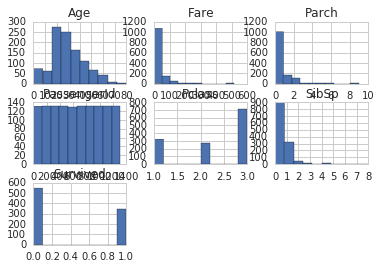

In [147]:
print(df.hist())

In [148]:
categorical_columns = ['Sex', 'Embarked']
numerical_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
text_columns = ['Name', 'Ticket']

def category_to_numeric(df, column_name):
    for category in df[column_name].unique():
        category_column = column_name + '_' + str(category)
        if category_column in df.columns:
            df = df.drop(category_column, axis=1)
        if category_column not in numerical_columns:
            numerical_columns.append(category_column)
    df= pd.concat([df,pd.get_dummies(df[column_name], prefix=column_name)],axis=1)
    return df

[[<matplotlib.axes._subplots.AxesSubplot object at 0x0A70ED90>


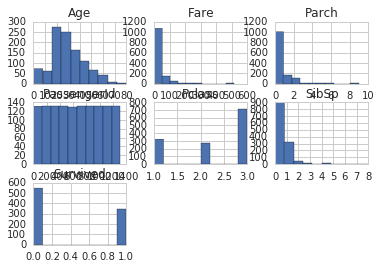

In [149]:
print(df.hist())

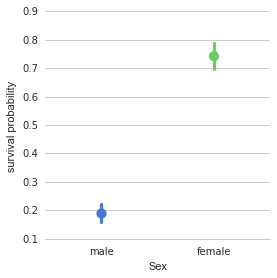

In [150]:
# Sex
import seaborn as sns
sns.set(style="whitegrid")

g = sns.factorplot(x="Sex", y="Survived", data=df, size=4, palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

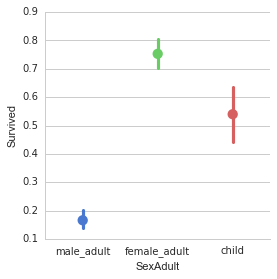

In [151]:
def get_sex_adult(row):
    age, sex = row
    if age < 18:
        return 'child'
    elif sex == 'female':
        return 'female_adult'
    else:
        return 'male_adult'

df['SexAdult'] = df[['Age', 'Sex']].apply(get_sex_adult, axis=1)
g = sns.factorplot(x="SexAdult", y="Survived", data=df, size=4, palette="muted")

if 'SexAdult' not in categorical_columns:
    categorical_columns.append('SexAdult')

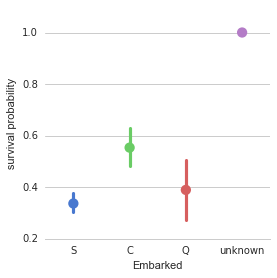

In [152]:
# Embarked
df['Embarked'] = df['Embarked'].fillna('unknown')
g = sns.factorplot(x="Embarked", y="Survived", data=df, size=4, palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

if 'Embarked' not in categorical_columns:
    categorical_columns.append('Embarked')

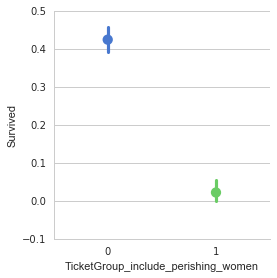

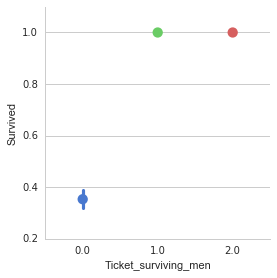

In [153]:
df_ticket = pd.DataFrame(df['Ticket'].value_counts())
df_ticket.rename(columns={'Ticket':'TicketMembers'}, inplace=True)

df_ticket['Ticket_perishing_women'] = df.Ticket[(df.SexAdult == 'female_adult')
                                               & (df.Survived == 0.0)
                                               & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_ticket['Ticket_perishing_women'] = df_ticket['Ticket_perishing_women'].fillna(0)
df_ticket['TicketGroup_include_perishing_women'] = df_ticket['Ticket_perishing_women'] > 0
df_ticket['TicketGroup_include_perishing_women'] = df_ticket['TicketGroup_include_perishing_women'].astype(int)

df_ticket['Ticket_surviving_men'] = df.Ticket[(df.SexAdult == 'male_adult')
                                              & (df.Survived == 1.0)
                                              & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_ticket['Ticket_surviving_men'] = df_ticket['Ticket_surviving_men'].fillna(0)
df_ticket['TicketGroup_include_surviving_men'] = df_ticket['Ticket_surviving_men'] > 0
df_ticket['TicketGroup_include_surviving_men'] = df_ticket['TicketGroup_include_surviving_men'].astype(int)

df_ticket["TicketId"] = pd.Categorical.from_array(df_ticket.index).codes
df_ticket.loc[df_ticket[df_ticket['TicketMembers'] < 3].index, "TicketId"] = -1
df_ticket["TicketMembers_Simple"] = pd.cut(df_ticket['TicketMembers'], bins=[0,1,4,20], labels=[0,1,2])
if 'TicketGroup_include_perishing_women' not in df.columns:
    df = pd.merge(df, df_ticket, left_on="Ticket", right_index=True, how='left', sort=False)

if 'Ticket_perishing_women' not in numerical_columns:
    numerical_columns.append('Ticket_perishing_women')
if 'TicketGroup_include_perishing_women' not in numerical_columns:
    numerical_columns.append('TicketGroup_include_perishing_women')
if 'Ticket_surviving_men' not in numerical_columns:
    numerical_columns.append('Ticket_surviving_men')
if 'TicketGroup_include_surviving_men' not in numerical_columns:
    numerical_columns.append('TicketGroup_include_surviving_men')
if 'TicketId' not in numerical_columns:
    numerical_columns.append('TicketId')
if 'TicketMembers' not in numerical_columns:
    numerical_columns.append('TicketMembers')
    
g = sns.factorplot(x="TicketGroup_include_perishing_women", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="Ticket_surviving_men", y="Survived", data=df, size=4, palette="muted")

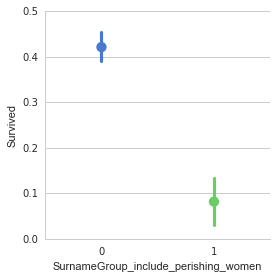

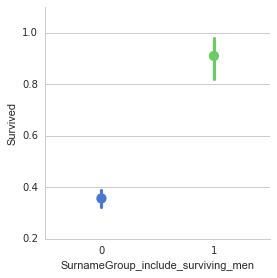

In [154]:
# surname
df['surname'] = df['Name'].apply(lambda x: x.split(',')[0].lower())
df_surname = pd.DataFrame(df['surname'].value_counts())
df_surname.rename(columns={'surname':'SurnameMembers'}, inplace=True)

df_surname['Surname_perishing_women'] = df.surname[(df.SexAdult == 'female_adult')
                                               & (df.Survived == 0.0)
                                               & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_surname['Surname_perishing_women'] = df_surname['Surname_perishing_women'].fillna(0)
df_surname['SurnameGroup_include_perishing_women'] = df_surname['Surname_perishing_women'] > 0
df_surname['SurnameGroup_include_perishing_women'] = df_surname['SurnameGroup_include_perishing_women'].astype(int)

df_surname['Surname_surviving_men'] = df.surname[(df.SexAdult == 'male_adult')
                                              & (df.Survived == 1.0)
                                              & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_surname['Surname_surviving_men'] = df_surname['Surname_surviving_men'].fillna(0)
df_surname['SurnameGroup_include_surviving_men'] = df_surname['Surname_surviving_men'] > 0
df_surname['SurnameGroup_include_surviving_men'] = df_surname['SurnameGroup_include_surviving_men'].astype(int)

df_surname["SurnameId"] = pd.Categorical.from_array(df_surname.index).codes
df_surname.loc[df_surname[df_surname['SurnameMembers'] < 3].index, "SurnameId"] = -1
df_surname["SurnameMembers_Simple"] = pd.cut(df_surname['SurnameMembers'], bins=[0,1,4,20], labels=[0,1,2])
if 'SurnameGroup_include_perishing_women' not in df.columns:
    df = pd.merge(df, df_surname, left_on="surname", right_index=True, how='left', sort=False)


if 'Surname_perishing_women' not in numerical_columns:
    numerical_columns.append('Surname_perishing_women')
if 'SurnameGroup_include_perishing_women' not in numerical_columns:
    numerical_columns.append('SurnameGroup_include_perishing_women')
if 'Surname_surviving_men' not in numerical_columns:
    numerical_columns.append('Surname_surviving_men')
if 'SurnameGroup_include_surviving_men' not in numerical_columns:
    numerical_columns.append('SurnameGroup_include_surviving_men')
if 'SurnameId' not in numerical_columns:
    numerical_columns.append('SurnameId')
if 'SurnameMembers' not in numerical_columns:
    numerical_columns.append('SurnameMembers')
    
g = sns.factorplot(x="SurnameGroup_include_perishing_women", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="SurnameGroup_include_surviving_men", y="Survived", data=df, size=4, palette="muted")

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Major' 'Lady' 'Sir'
 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


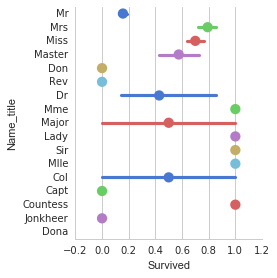

In [155]:
# title
import re
df['Name_title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))
df.loc[df[df['Name_title'] == 'Ms'].index, 'Name_title'] = 'Miss'
print(df['Name_title'].unique())
if 'Name_title' not in categorical_columns:
    categorical_columns.append('Name_title')
g = sns.factorplot(y="Name_title", x="Survived", data=df, size=4, palette="muted")

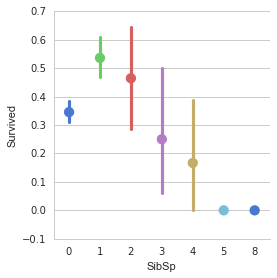

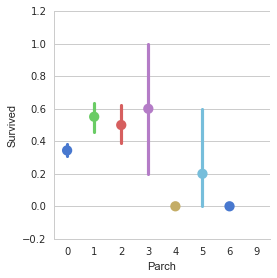

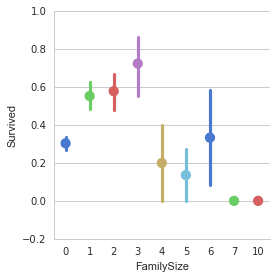

In [156]:
# FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch']
if 'FamilySize' not in numerical_columns:
    numerical_columns.append('FamilySize')
g = sns.factorplot(x="SibSp", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="Parch", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="FamilySize", y="Survived", data=df, size=4, palette="muted")

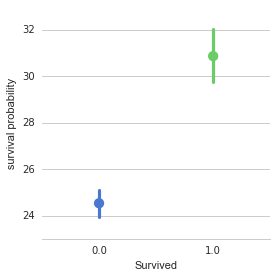

In [157]:
# Name Length?
df['NameLength'] = df["Name"].apply(lambda x: len(x))
if 'NameLength' not in numerical_columns:
    numerical_columns.append('NameLength')
g = sns.factorplot(y="NameLength", x="Survived", data=df, size=4, palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

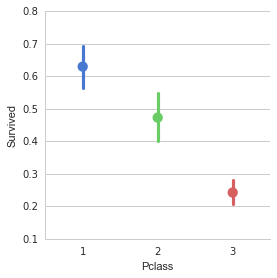

In [158]:
# Pclass
g = sns.factorplot(x="Pclass", y="Survived", data=df, size=4, palette="muted")

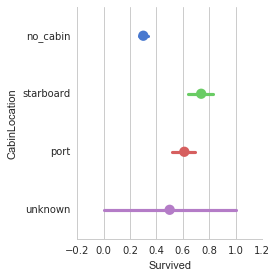

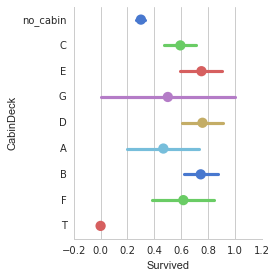

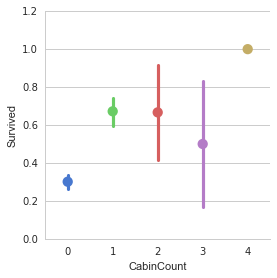

In [159]:
# cabin
# https://www.kaggle.com/c/titanic/prospector#1326
def get_cabin_location(cabin):
    if cabin == ' ':
        return 'no_cabin'
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('\d+', cabin)
    if cabin_search_result:
        type_code = np.int64(cabin_search_result.group(0))
        if type_code % 2 == 0:
            return 'port'
        else:
            return 'starboard'
    return 'unknown'

def get_cabin_deck(cabin):
    if cabin == ' ':
        return 'no_cabin'
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('[A-z]+', cabin)
    if cabin_search_result:
        return cabin_search_result.group(0)
    return 'unknown'

def get_cabin_count(cabin):
    if cabin == ' ':
        return 0
    cabin_search_result = re.findall('([A-z]\d+)', cabin)
    if cabin_search_result:
        return len(cabin_search_result)
    return 0

df['CabinLocation'] = df['Cabin'].fillna(' ').apply(get_cabin_location)
df['CabinDeck'] = df['Cabin'].fillna(' ').apply(get_cabin_deck)
df['CabinCount'] = df['Cabin'].fillna(' ').apply(get_cabin_count)

if 'CabinLocation' not in categorical_columns:
    categorical_columns.append('CabinLocation')
if 'CabinDeck' not in categorical_columns:
    categorical_columns.append('CabinDeck')
if 'CabinCount' not in numerical_columns:
    numerical_columns.append('CabinCount')

g = sns.factorplot(x="Survived", y="CabinLocation", data=df, size=4, palette="muted")
g = sns.factorplot(x="Survived", y="CabinDeck", data=df, size=4, palette="muted")
g = sns.factorplot(x="CabinCount", y="Survived", data=df, size=4, palette="muted")

count    1309.000000
mean       33.295479
std        51.738879
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64
Axes(0.125,0.125;0.775x0.775)


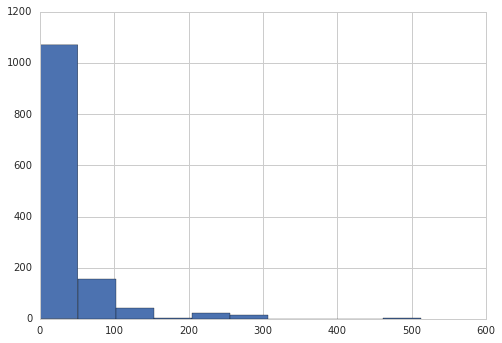

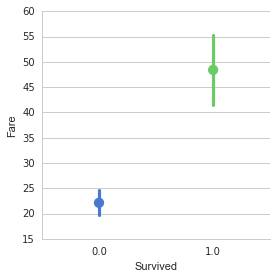

In [160]:
# Fare
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
print(df['Fare'].describe())
print(df['Fare'].hist())
g = sns.factorplot(x="Survived", y="Fare", data=df, size=4, palette="muted")

   Pclass     Fare  TicketMembers
0       3   7.2500              1
1       1  71.2833              2
2       3   7.9250              1
3       1  53.1000              2
4       3   8.0500              1
Axes(0.125,0.125;0.775x0.775)


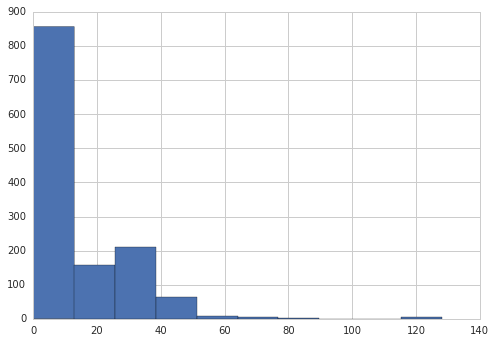

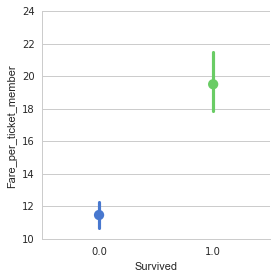

In [161]:
df['TicketMembers'] = df['TicketMembers'].fillna(0)
print(df.head()[['Pclass','Fare', 'TicketMembers']])
df['Fare_per_ticket_member'] = df['Fare'] / (df['TicketMembers'])
print(df['Fare_per_ticket_member'].hist())
g = sns.factorplot(x="Survived", y="Fare_per_ticket_member", data=df, size=4, palette="muted")

In [162]:
from math import log

class_fare = pd.DataFrame(columns=['count','mean','std','min','25%','50%','75%','max'])
class_fare.loc[1,:] = df[df['Pclass'] == 1]['Fare'].describe()
class_fare.loc[2,:] = df[df['Pclass'] == 2]['Fare'].describe()
class_fare.loc[3,:] = df[df['Pclass'] == 3]['Fare'].describe()

very_small_val = 0.01
df['Fare_standard_score_with_Pclass'] = df.apply(lambda row: (log(row['Fare'] + very_small_val) - log(class_fare.loc[row['Pclass'], 'mean'] + very_small_val)) / log(class_fare.loc[row['Pclass'], 'std'] + very_small_val), axis=1)
if 'Fare_standard_score_with_Pclass' not in numerical_columns:
    numerical_columns.append('Fare_standard_score_with_Pclass')

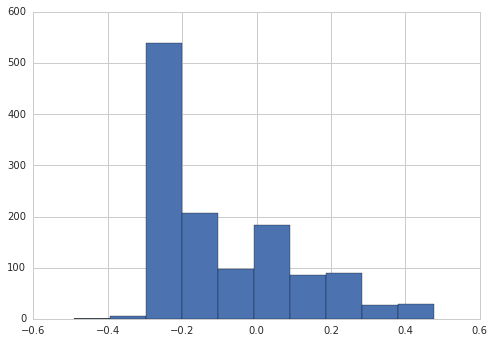

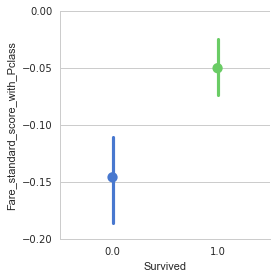

In [163]:
df[(df['Fare_standard_score_with_Pclass'] >= -0.5) & (df['Fare_standard_score_with_Pclass'] <= 0.5)]['Fare_standard_score_with_Pclass'].hist()
g = sns.factorplot(x="Survived", y="Fare_standard_score_with_Pclass", data=df, size=4, palette="muted")

In [164]:
from math import log

class_fare = pd.DataFrame(columns=['count','mean','std','min','25%','50%','75%','max'])
class_fare.loc[1,:] = df[df['Pclass'] == 1]['Fare_per_ticket_member'].describe()
class_fare.loc[2,:] = df[df['Pclass'] == 2]['Fare_per_ticket_member'].describe()
class_fare.loc[3,:] = df[df['Pclass'] == 3]['Fare_per_ticket_member'].describe()

very_small_val = 0.01
df['Fare_per_ticket_member_standard_score_with_Pclass'] = df.apply(lambda row: (log(row['Fare_per_ticket_member'] + very_small_val) - log(class_fare.loc[row['Pclass'], 'mean'] + very_small_val)) / log(class_fare.loc[row['Pclass'], 'std'] + very_small_val), axis=1)
if 'Fare_per_ticket_member_standard_score_with_Pclass' not in numerical_columns:
    numerical_columns.append('Fare_per_ticket_member_standard_score_with_Pclass')

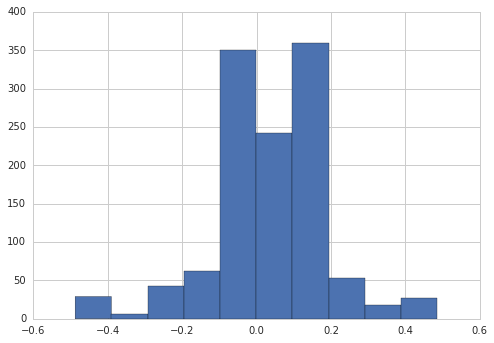

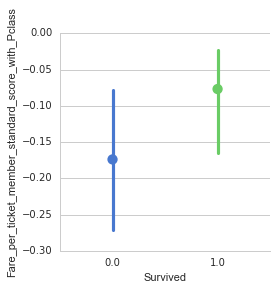

In [165]:
df[(df['Fare_per_ticket_member_standard_score_with_Pclass'] >= -0.5) & (df['Fare_per_ticket_member_standard_score_with_Pclass'] <= 0.5)]['Fare_per_ticket_member_standard_score_with_Pclass'].hist()
g = sns.factorplot(x="Survived", y="Fare_per_ticket_member_standard_score_with_Pclass", data=df, size=4, palette="muted")

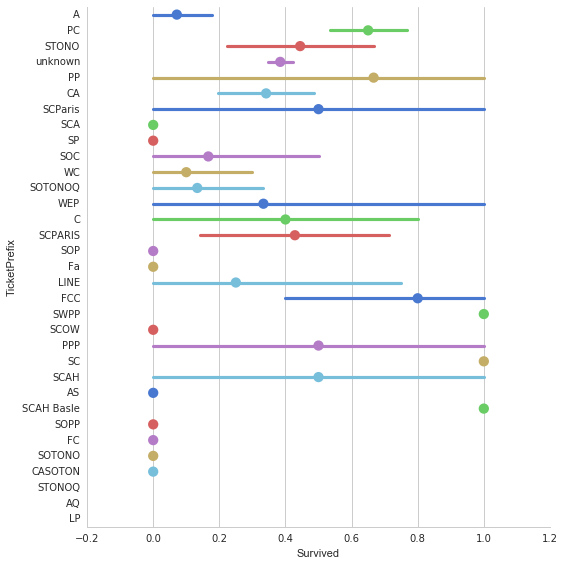

In [166]:
# https://www.kaggle.com/c/titanic/forums/t/11127/do-ticket-numbers-mean-anything
#print(df["Ticket"])
#print(df["Ticket"].value_counts())

def get_ticket_prefix(cabin):
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('[^\d]+', cabin)
    if cabin_search_result:
        return cabin_search_result.group(0).replace('/', '').replace('.', '').strip()
    return 'unknown'

df['TicketPrefix'] = df['Ticket'].apply(get_ticket_prefix)
g = sns.factorplot(y="TicketPrefix", x="Survived", data=df, size=8, palette="muted")

if 'TicketPrefix' not in categorical_columns:
    categorical_columns.append('TicketPrefix')

In [167]:
for col in categorical_columns:
    df = category_to_numeric(df, col)

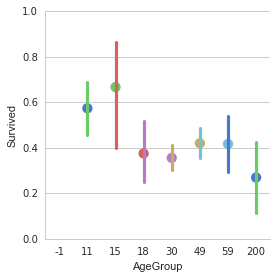

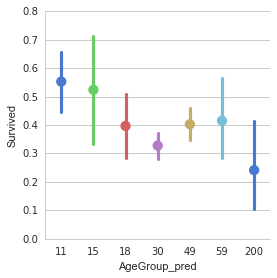

In [181]:
# age prediction
from sklearn.ensemble import ExtraTreesRegressor

age_prediction_features = ['Fare', 'Fare_standard_score_with_Pclass',
                           #'Fare_per_ticket_member', 'Fare_per_ticket_member_standard_score_with_Pclass',
                           'Parch', 'Pclass', 'SibSp', 'Sex_female', 'Sex_male', 'FamilySize',
                           'NameLength', 'TicketMembers', 'TicketId', 
                           'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_unknown', 
                           'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 'Name_title_Master', 
                           'Name_title_Don', 'Name_title_Rev', 'Name_title_Dr', 'Name_title_Mme', 
                           'Name_title_Major', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Col', 
                           'Name_title_Capt', 'Name_title_Countess', 'Name_title_Jonkheer', 
                           'CabinLocation_no_cabin', 'CabinLocation_starboard', 'CabinLocation_port', 'CabinDeck_no_cabin', 
                           'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_G', 'CabinDeck_D', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_F', 'CabinDeck_T']
age_prediction_tree_regressor = ExtraTreesRegressor(n_estimators=200)
age_X_train = df[age_prediction_features][df['Age'].notnull()]
age_Y_train = df['Age'][df['Age'].notnull()]
age_prediction_tree_regressor.fit(age_X_train, np.ravel(age_Y_train))

# predict only isnull values
df['Age_pred'] = df['Age']
df.loc[df[df['Age'].isnull()].index, 'Age_pred'] = age_prediction_tree_regressor.predict(df[age_prediction_features][df['Age'].isnull()])

if 'Age_pred' not in numerical_columns:
    numerical_columns.append('Age_pred')

# add ageGroup
df["AgeGroup"] = pd.cut(df['Age'], bins=[-2000,0,11,15,18,30,49,59,200], labels=[-1, 11,15,18,30,49,59,200])
df["AgeGroup_pred"] = pd.cut(df['Age_pred'], bins=[-2000,11,15,18,30,49,59,200], labels=[11,15,18,30,49,59,200])

if 'AgeGroup' not in numerical_columns:
    numerical_columns.append('AgeGroup')
if 'AgeGroup_pred' not in numerical_columns:
    numerical_columns.append('AgeGroup_pred')
    
g = sns.factorplot(y="Survived", x="AgeGroup", data=df, size=4, palette="muted")
g = sns.factorplot(y="Survived", x="AgeGroup_pred", data=df, size=4, palette="muted")

In [169]:
# Frugal_First_Class_Single_Man
# midle age first class single man with large discounted and unknown prefixed ticket and without cabin.
print("died", df[(df['Survived'] == 0) & (df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)
        ])
print("survived", df[(df['Survived'] == 1) & (df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)
        ])

('died', Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket, SexAdult, TicketMembers, Ticket_perishing_women, TicketGroup_include_perishing_women, Ticket_surviving_men, TicketGroup_include_surviving_men, TicketId, TicketMembers_Simple, surname, SurnameMembers, Surname_perishing_women, SurnameGroup_include_perishing_women, Surname_surviving_men, SurnameGroup_include_surviving_men, SurnameId, SurnameMembers_Simple, Name_title, FamilySize, NameLength, CabinLocation, CabinDeck, CabinCount, Fare_per_ticket_member, Fare_standard_score_with_Pclass, Fare_per_ticket_member_standard_score_with_Pclass, TicketPrefix, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S, Embarked_unknown, SexAdult_child, SexAdult_female_adult, SexAdult_male_adult, Name_title_Capt, Name_title_Col, Name_title_Countess, Name_title_Don, Name_title_Dona, Name_title_Dr, Name_title_Jonkheer, Name_title_Lady, Name_title_Major, Name_title_Master, Name_tit

In [170]:
df['Frugal_First_Class_Single_Man'] = 0
df.loc[df[(df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)]['Frugal_First_Class_Single_Man'].index, 'Frugal_First_Class_Single_Man'] = 1
print(df[(df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)]['Frugal_First_Class_Single_Man'])
if 'Frugal_First_Class_Single_Man' not in numerical_columns:
    numerical_columns.append('Frugal_First_Class_Single_Man')

187     1
447     1
507     1
604     1
985     1
1035    1
1214    1
Name: Frugal_First_Class_Single_Man, dtype: int64


In [191]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

df_copied = df.copy()
df_copied['Cabin'] = df_copied['Cabin'].fillna(' ')
df_copied['Age'] = df_copied['Age'].fillna(-300)
df_copied['AgeGroup'] = df_copied['AgeGroup'].fillna(-1.0)

train = df_copied[0:891].copy()
target = train["Survived"].values

print(train)

selector = SelectKBest(f_classif, k=len(numerical_columns))
selector.fit(train[numerical_columns], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],numerical_columns[indices[f]]))

       Age        Cabin Embarked      Fare  \
0     22.0                     S    7.2500   
1     38.0          C85        C   71.2833   
2     26.0                     S    7.9250   
3     35.0         C123        S   53.1000   
4     35.0                     S    8.0500   
5   -300.0                     Q    8.4583   
6     54.0          E46        S   51.8625   
7      2.0                     S   21.0750   
8     27.0                     S   11.1333   
9     14.0                     C   30.0708   
10     4.0           G6        S   16.7000   
11    58.0         C103        S   26.5500   
12    20.0                     S    8.0500   
13    39.0                     S   31.2750   
14    14.0                     S    7.8542   
15    55.0                     S   16.0000   
16     2.0                     Q   29.1250   
17  -300.0                     S   13.0000   
18    31.0                     S   18.0000   
19  -300.0                     C    7.2250   
20    35.0                     S  

In [242]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, train[numerical_columns], target, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(train[numerical_columns], target)
score = random_forest.score(train[numerical_columns], target)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(numerical_columns)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, numerical_columns[indices[f]]))



Accuracy: 90.123 (+/- 1.38) [Random Forest Cross Validation]
Accuracy: 96.857             [Random Forest full test]
1. feature 24 (5.440141) Sex_female
2. feature 23 (5.160717) Sex_male
3. feature 5 (4.862219) Fare
4. feature 19 (4.853921) NameLength
5. feature 32 (4.746910) Name_title_Mr
6. feature 29 (4.713162) SexAdult_male_adult
7. feature 95 (4.529091) Age_pred
8. feature 21 (4.161977) Fare_standard_score_with_Pclass
9. feature 30 (3.881129) SexAdult_female_adult
10. feature 7 (3.801670) TicketGroup_include_perishing_women
11. feature 6 (3.686838) Ticket_perishing_women
12. feature 22 (3.537004) Fare_per_ticket_member_standard_score_with_Pclass
13. feature 12 (3.449129) Surname_perishing_women
14. feature 13 (3.440801) SurnameGroup_include_perishing_women
15. feature 2 (3.127522) Age
16. feature 1 (3.037891) Pclass
17. feature 8 (2.525648) Ticket_surviving_men
18. feature 9 (2.376385) TicketGroup_include_surviving_men
19. feature 11 (2.121536) TicketMembers
20. feature 33 (1.87382

In [334]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

ensemble_clfs = [
    ("RandomForestClassifier",
        RandomForestClassifier(
                               n_estimators=3000,
                               n_jobs=8,
                               class_weight={0:0.745, 1:0.255},
                               min_samples_split=4,
                               random_state=42)),
]

kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

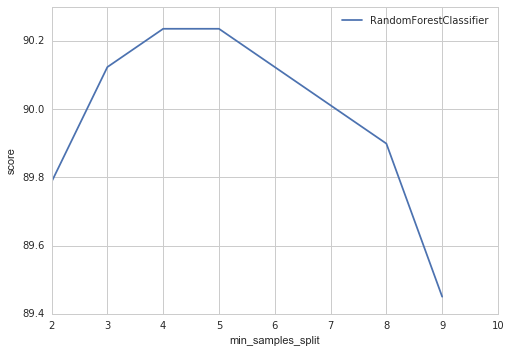

In [332]:
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
for label, clf in ensemble_clfs:
    print("Classifier : %s" % label)
    for i in range(2, 10):
        clf.set_params(min_samples_split=i)
        clf.fit(train[numerical_columns], target)
        scores = cross_validation.cross_val_score(clf, train[numerical_columns], target, cv=kfold)
        error_rate[label].append((i, scores.mean() * 100))
        print("%d estimator" % i)
        
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    
plt.xlim(2, 10)
plt.xlabel("min_samples_split")
plt.ylabel("score")
plt.legend(loc="upper right")
plt.show()

Classifier : RandomForestClassifier
max_depth : 1
max_depth : 11
max_depth : 21
max_depth : 31
max_depth : 41
max_depth : 51
max_depth : 61
max_depth : 71
max_depth : 81
max_depth : 91


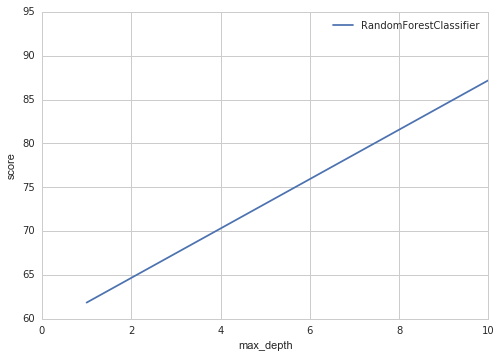

In [336]:
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
for label, clf in ensemble_clfs:
    print("Classifier : %s" % label)
    for i in range(1, 100, 10):
        clf.set_params(max_depth=i)
        clf.fit(train[numerical_columns], target)
        scores = cross_validation.cross_val_score(clf, train[numerical_columns], target, cv=kfold)
        error_rate[label].append((i, scores.mean() * 100))
        print("max_depth : %d" % i)
        
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    
plt.xlim(0, 10)
plt.xlabel("max_depth")
plt.ylabel("score")
plt.legend(loc="upper right")
plt.show()

In [241]:
# select specidic features
features = [
            'Age_pred','AgeGroup_pred',
            'Sex_female','Sex_male',
            'SexAdult_male_adult','SexAdult_female_adult', 'SexAdult_child',
    
            'TicketGroup_include_perishing_women','TicketGroup_include_surviving_men',
            'SurnameGroup_include_perishing_women','SurnameGroup_include_surviving_men',
            'FamilySize',

            'Pclass', 
            'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 
            'Frugal_First_Class_Single_Man',
    
            'Fare_standard_score_with_Pclass', 'Fare_per_ticket_member_standard_score_with_Pclass',
    
            'TicketPrefix_unknown', 
            'TicketPrefix_SCA','TicketPrefix_SP','TicketPrefix_SOP','TicketPrefix_Fa','TicketPrefix_SCOW','TicketPrefix_AS','TicketPrefix_SOPP',
            'TicketPrefix_FC','TicketPrefix_SOTONO','TicketPrefix_CASOTON','TicketPrefix_SWPP','TicketPrefix_SC','TicketPrefix_SCAH Basle',
    
            'CabinCount',
            'CabinDeck_T',
    
            'Name_title_Don','Name_title_Rev','Name_title_Capt','Name_title_Jonkheer', 
            'Name_title_Mme', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Countess', 
    
           ]

random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, train[features], target, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(train[features], target)
score = random_forest.score(train[features], target)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, features[indices[f]]))

Accuracy: 90.572 (+/- 1.98) [Random Forest Cross Validation]
Accuracy: 96.970             [Random Forest full test]
1. feature 1 (10.696507) Age_pred
2. feature 18 (9.362567) Fare_standard_score_with_Pclass
3. feature 8 (7.905781) TicketGroup_include_perishing_women
4. feature 19 (7.876323) Fare_per_ticket_member_standard_score_with_Pclass
5. feature 10 (7.802087) SurnameGroup_include_perishing_women
6. feature 4 (6.268391) Sex_male
7. feature 13 (5.981468) Pclass
8. feature 14 (5.863216) Name_title_Mr
9. feature 3 (5.279067) Sex_female
10. feature 9 (4.827303) TicketGroup_include_surviving_men
11. feature 5 (4.674817) SexAdult_male_adult
12. feature 6 (3.565296) SexAdult_female_adult
13. feature 12 (3.548984) FamilySize
14. feature 2 (3.178355) AgeGroup_pred
15. feature 34 (2.956147) CabinCount
16. feature 11 (2.731669) SurnameGroup_include_surviving_men
17. feature 15 (2.093398) Name_title_Mrs
18. feature 16 (1.678687) Name_title_Miss
19. feature 17 (1.010976) Frugal_First_Class_Sing

In [243]:
# analyze failed.
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train, target, test_size=0.2, random_state=42)
random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(X_train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, X_train[features], y_train, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(X_train[features], y_train)
score = random_forest.score(X_test[features], y_test)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))
pred_test = random_forest.predict(X_test[features])

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, features[indices[f]]))

Accuracy: 88.905 (+/- 0.50) [Random Forest Cross Validation]
Accuracy: 93.855             [Random Forest full test]
1. feature 1 (10.880144) Age_pred
2. feature 18 (9.291424) Fare_standard_score_with_Pclass
3. feature 19 (7.934715) Fare_per_ticket_member_standard_score_with_Pclass
4. feature 8 (7.190457) TicketGroup_include_perishing_women
5. feature 10 (7.063907) SurnameGroup_include_perishing_women
6. feature 13 (6.934591) Pclass
7. feature 4 (6.201556) Sex_male
8. feature 14 (5.358844) Name_title_Mr
9. feature 3 (5.318493) Sex_female
10. feature 5 (4.829811) SexAdult_male_adult
11. feature 9 (4.618934) TicketGroup_include_surviving_men
12. feature 6 (4.295776) SexAdult_female_adult
13. feature 12 (3.531037) FamilySize
14. feature 2 (3.103360) AgeGroup_pred
15. feature 11 (2.970485) SurnameGroup_include_surviving_men
16. feature 34 (2.831625) CabinCount
17. feature 15 (2.747426) Name_title_Mrs
18. feature 16 (1.716277) Name_title_Miss
19. feature 20 (1.001861) TicketPrefix_unknown
20

In [254]:
pd.set_option("display.max_columns",101)
X_test_reseted = X_test.reset_index()
X_test_reseted['Survived_'] = y_test
X_test_reseted['Prediction'] = pred_test
X_test_reseted['pred_result'] = pred_test == y_test
print(X_test_reseted[(X_test_reseted['Survived'] == 1.0) & (X_test_reseted['pred_result'] == False)])
print(X_test_reseted[(X_test_reseted['Survived'] == 0.0) & (X_test_reseted['pred_result'] == False)])

     index   Age Cabin Embarked   Fare                          Name  Parch  \
27     673  31.0              S  13.00         Wilhelms, Mr. Charles      0   
34     204  18.0              S   8.05      Cohen, Mr. Gurshon "Gus"      0   
36      23  28.0    A6        S  35.50  Sloper, Mr. William Thompson      0   
72     889  26.0  C148        C  30.00         Behr, Mr. Karl Howell      0   
97     338  45.0              S   8.05         Dahl, Mr. Karl Edwart      0   
108    286  30.0              S   9.50       de Mulder, Mr. Theodore      0   
109    209  40.0   A31        C  31.00              Blank, Mr. Henry      0   

     PassengerId  Pclass   Sex  SibSp  Survived    Ticket    SexAdult  \
27           674       2  male      0       1.0    244270  male_adult   
34           205       3  male      0       1.0  A/5 3540  male_adult   
36            24       1  male      0       1.0    113788  male_adult   
72           890       1  male      0       1.0    111369  male_adult   
97

In [301]:
random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
test = df_copied[891:].copy()
random_forest.fit(train[features], target)
predictions = random_forest.predict(test[features])

In [302]:
PassengerId = np.array(test["PassengerId"]).astype(int)
submit_df = pd.DataFrame(predictions, PassengerId, columns = ['Survived']).astype(int)
submit_df.to_csv('titanic.csv', index_label=['PassengerId'])

In [308]:
yhyu13_subimt_df = pd.read_csv("yhyu13_submit.csv")
yhyu13_subimt_df = yhyu13_subimt_df.reset_index().drop('index', axis=1)
yhyu13_subimt_df = yhyu13_subimt_df.set_index('PassengerId')
diff = submit_df.copy()
diff['Survived_yhyu13'] = yhyu13_subimt_df['Survived']
diff['pred_result'] = diff['Survived_yhyu13'] == diff['Survived']

In [307]:
print(df.loc[diff[(diff['Survived_yhyu13'] == 1.0) & (diff['pred_result'] == False)].index, :])

       Age            Cabin Embarked      Fare  \
899   18.0              NaN        C    7.2292   
909   27.0              NaN        S    7.9250   
915   48.0  B57 B59 B63 B66        C  262.3750   
926   18.5              NaN        C    7.2292   
931   39.0              NaN        C   13.4167   
932    NaN              D34        S   26.5500   
937   45.0               A9        C   29.7000   
938    NaN              NaN        Q    7.7500   
960   60.0      C23 C25 C27        S  263.0000   
964   28.5              D43        C   27.7208   
979    NaN              NaN        Q    7.7500   
1023   NaN              NaN        S   25.4667   
1030  40.0              NaN        S   46.9000   
1040  30.0              NaN        S   26.0000   
1061   NaN              NaN        S    7.5500   
1069  36.0               F4        S   39.0000   
1093  47.0          C62 C64        C  227.5250   
1094   8.0              NaN        S   26.0000   
1097  35.0              NaN        Q    7.7500   


In [309]:
print(df.loc[diff[(diff['Survived_yhyu13'] == 0.0) & (diff['pred_result'] == False)].index, :])

        Age    Cabin Embarked      Fare  \
898   26.00      NaN        S   29.0000   
927     NaN      NaN        S    8.0500   
957   18.00      NaN        Q    7.8792   
958   47.00      NaN        S   42.4000   
962   21.00      NaN        S    7.8958   
971    6.00      NaN        C   15.2458   
986   25.00      NaN        S    7.7958   
996   28.00      NaN        S   22.5250   
1005  63.00  C55 C57        S  221.7792   
1006  18.00      NaN        C   14.4542   
1036  31.00      NaN        S   18.0000   
1045  13.00      NaN        S   31.3875   
1051    NaN      NaN        Q    7.7333   
1084  61.00      NaN        Q   12.3500   
1089  23.00      NaN        S   10.5000   
1106  42.00      B11        S   42.5000   
1117  23.00      NaN        S    7.7958   
1130  48.00      C86        C  106.4250   
1141   0.92      NaN        S   27.7500   
1155  30.00      NaN        C   12.7375   
1173    NaN      NaN        Q    7.7500   
1175   2.00      NaN        S   20.2125   
1183    NaN